# Module 12: Object Detection with OpenCV and Tensorflow
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1bwXSm513ES0e4PdQNQ4eAPomZTll1hPY?usp=sharing)



This notebook demonstrates object detection using the `cv2.dnn` module in OpenCV, powered by a pre-trained TensorFlow model (`SSD_MobileNet_V2_COCO`).

###  What You'll Learn:
- How to load a deep learning model for object detection.
- How to use OpenCV’s `dnn` module to process images.
- How to extract and display detected objects with bounding boxes and class labels.
- How to fine-tune the detection threshold for better accuracy.

###  Tools Used:
- **OpenCV (cv2):** Image I/O and deep learning model handling.
- **TensorFlow Model (SSD + MobileNet V2):** Pre-trained on the COCO dataset (90 common object classes).
- **Matplotlib:** Visualizing detection results inside the notebook.
- **NumPy:** Handling image arrays and coordinate calculations.

---

This is a beginner-friendly, hands-on project where you’ll not only use a real object detection model but also understand how each part works under the hood.





## Step 1: Import Required Libraries

### Why these libraries?
- `cv2`: OpenCV library for image processing and object detection.
- `matplotlib.pyplot`: For displaying images and visual results.
- `%matplotlib inline`: Makes plots display directly in the notebook.
- `numpy`: Handles numerical operations and image arrays.

In [115]:
#Importing Libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Step 2: Load COCO Class Labels

Object detection models detect specific classes (like person, car, dog, etc.). These classes are usually listed in a separate file.

- `coco_class_labels.txt` contains the names of the 80 object classes used in the COCO dataset.
- We use basic file I/O in Python to read the file and split it into a list of labels.

### Example classes:
- person
- bicycle
- car




In [116]:
#Checking from the class label text
#Using the file I/O
with open('coco_class_labels.txt') as file:
  labels=file.read().split('\n')
print(labels)

['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', '']


## Step 3: Load the Pre-trained Object Detection Model

We're using a pre-trained model based on **TensorFlow's SSD MobileNet V2**, trained on the COCO dataset.

### Files used:
- `frozen_inference_graph.pb`: Contains the model's trained weights.
- `ssd_mobilenet_v2_coco_2018_03_29.pbtxt`: Configuration file that describes the model architecture and how it connects the layers.

### How it's used in OpenCV:
OpenCV’s `dnn` module can read TensorFlow models using `cv2.dnn.readNetFromTensorflow()` which takes:
- First argument: **path to the weights** file (`.pb`)
- Second argument: **path to the config** file (`.pbtxt`)

### Pre-trained Weights
You can download the pre-trained weights from this GitHub link:

[Download the pre-trained weights](https://github.com/TannerGilbert/Tensorflow-Object-Detection-API-train-custom-Mask-R-CNN-model/blob/master/frozen_inference_graph.pb)



In [117]:
# Reading the weights and architecture using the TensorFlow model format
# frozen_inference_graph.pb = weights
# ssd_mobilenet_v2_coco_2018_03_29.pbtxt = architecture/config

net=cv2.dnn.readNetFromTensorflow('frozen_inference_graph.pb','ssd_mobilenet_v2_coco_2018_03_29.pbtxt') #The models are in same

#Tensorflow needs 2 arguments (model/weights[str]),(architeture/Configrurations[str])

# Pretrained model link (for weights):
# https://github.com/TannerGilbert/Tensorflow-Object-Detection-API-train-custom-Mask-R-CNN-model/blob/master/frozen_inference_graph.pb


## Step 4: Define Object Detection Function

To avoid repeating code for every image, we define a reusable `detect()` function.

### What this function does:
- Converts the input image into a **blob** using `cv2.dnn.blobFromImage()`:
  - `scalefactor=1`: No rescaling of pixel values.
  - `size=(300, 300)`: Resizes the image to match what the model expects.
  - `mean=(0, 0, 0)`: No mean subtraction (can be used to normalize, if needed).
  - `swapRB=True`: Swaps Red and Blue channels because OpenCV loads images in BGR, but most models are trained on RGB.
  - `crop=False`: Keeps the full image.

- Sets the blob as input to the network using `net.setInput()`.
- Runs a forward pass with `net.forward()` to get **predicted objects** (bounding boxes, class IDs, confidence scores).
- Returns the raw output (predictions).

This function can be reused for multiple input images.


In [118]:
#Detectionof object
#Here we are making a function for this as for output we can have multiple examples otherwise fi=or each example  we have to make all of this
def detect(net,img):
  blob=cv2.dnn.blobFromImage(img,scalefactor=1,size=(300,300),mean=(0,0,0),swapRB=True,crop=False)#SwapRB =True coz the img is from downloaded which wa in RGB from and not in opencv bgr

  net.setInput(blob)

  objects=net.forward() #Objects here are the Prediction/inferences which was makde through the weight of tensorflow models and then process that in blob to make it optimised for network.forward funtion

  return objects

## Step 5: Function to Display Labels on Detected Objects

After detecting objects, we need to draw their class labels on the image. This function helps overlay readable text.

### What it does:
- Takes the **image**, **label text**, and **(x, y)** coordinates.
- Calculates the **size of the text** using `cv2.getTextSize()`:
  - Returns a tuple: `(width, height), baseline`
  - `textSize[0]`: Size of the text in pixels → (width, height)
  - `textSize[1]`: Baseline → space below the text to the bottom of the bounding box

### Drawing:
- First draws a **filled rectangle** to act as a background for the text (for better visibility).
- Then writes the text using `cv2.putText()` on top of that box.


In [119]:
# Function to draw text labels over detected objects
def display_text(img, text, x, y):
    # Get the size of the text (returns ((width, height), baseline))
    textSize = cv2.getTextSize(text, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, thickness=1)
    dim = textSize[0]         # Tuple (width, height)
    baseline = textSize[1]    # Number of pixels from text bottom to baseline

    # Draw a filled rectangle to make the label visible
    cv2.rectangle(img,
                  (x, y - dim[1] - baseline),
                  (x + dim[0], y + baseline),
                  (125, 0, 125),
                  cv2.FILLED)

    # Put the text label on top of the rectangle
    cv2.putText(img,
                text,
                (x, y - 5),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.7,
                color=(0, 255, 0),
                thickness=2)


## Step 6: Display Detected Objects with Bounding Boxes

This function draws bounding boxes and labels for detected objects on the image.

### Parameters:
- `img`: The original image (in BGR format as loaded by OpenCV)
- `objects`: Output from `net.forward()` — contains detections
- `threshold`: Confidence threshold to filter weak detections (default: 0.3)

### How it works:
1. Gets image height (`rows`) and width (`cols`) from `img.shape`.
2. Iterates over each detection in `objects[0, 0, i]`.
3. For each detection:
   - `classId`: Index of predicted class (from COCO label list)
   - `score`: Confidence score of prediction
   - Bounding box coordinates (normalized) are converted to pixel positions.
4. If `score > threshold`:
   - Draws a rectangle around the object
   - Places a text label above it using the `display_text()` helper
5. Converts the image from BGR to RGB for displaying with `matplotlib`.

### Notes:
- Coordinates returned by the model are **normalized between 0 and 1**, so we multiply by image width/height to scale them.
- OpenCV uses BGR format, but matplotlib needs RGB, hence the conversion before displaying.


In [120]:
#Displaying the objects

def display_objects(img, objects, threshold = 0.3): #Lesser the threshold greater the sensitivity ;default threshold=0.3
    #is this capturing the pixels??
    rows = img.shape[0]; cols = img.shape[1] #As this is a numpy funtion thats why its in row and col and not as opencv convention

    # For every Detected Object
    for i in range(objects.shape[2]): #as object is an net.forward object and at index 2 is where the detect infernce is there
        # Find the class and confidence
        classId = int(objects[0, 0, i, 1]) #here 1 means column Label
        score = float(objects[0, 0, i, 2]) #2 means threshold to which extent its matches with the label

        # Recover original cordinates from normalized coordinates
        #Rectangle bound box
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)

        # Check if the detection is of good quality
        if score > threshold:
            display_text(img, "{}".format(labels[classId]), x, y)#USes above functionto make corresponded detected label text filled box
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2) #Makes a box aount the detected object

    # Convert Image to RGB since we are using Matplotlib for displaying image
    mp_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30,10)); plt.imshow(mp_img); plt.show();

## Step 7: Run Detection on an Image

We now:
- Load the input image using OpenCV.
- Pass it to the `detect()` function.
- Display detected objects using `display_objects()`.

### 🔧 Tuning Detection Threshold

The `threshold` parameter controls how confident the model must be before labeling an object:

- Higher threshold (e.g., 0.5–0.7): Fewer, more accurate detections.
- Lower threshold (e.g., 0.2–0.3): More detections, but potentially noisy.

You can adjust it depending on how precise or sensitive you want the detection to be.


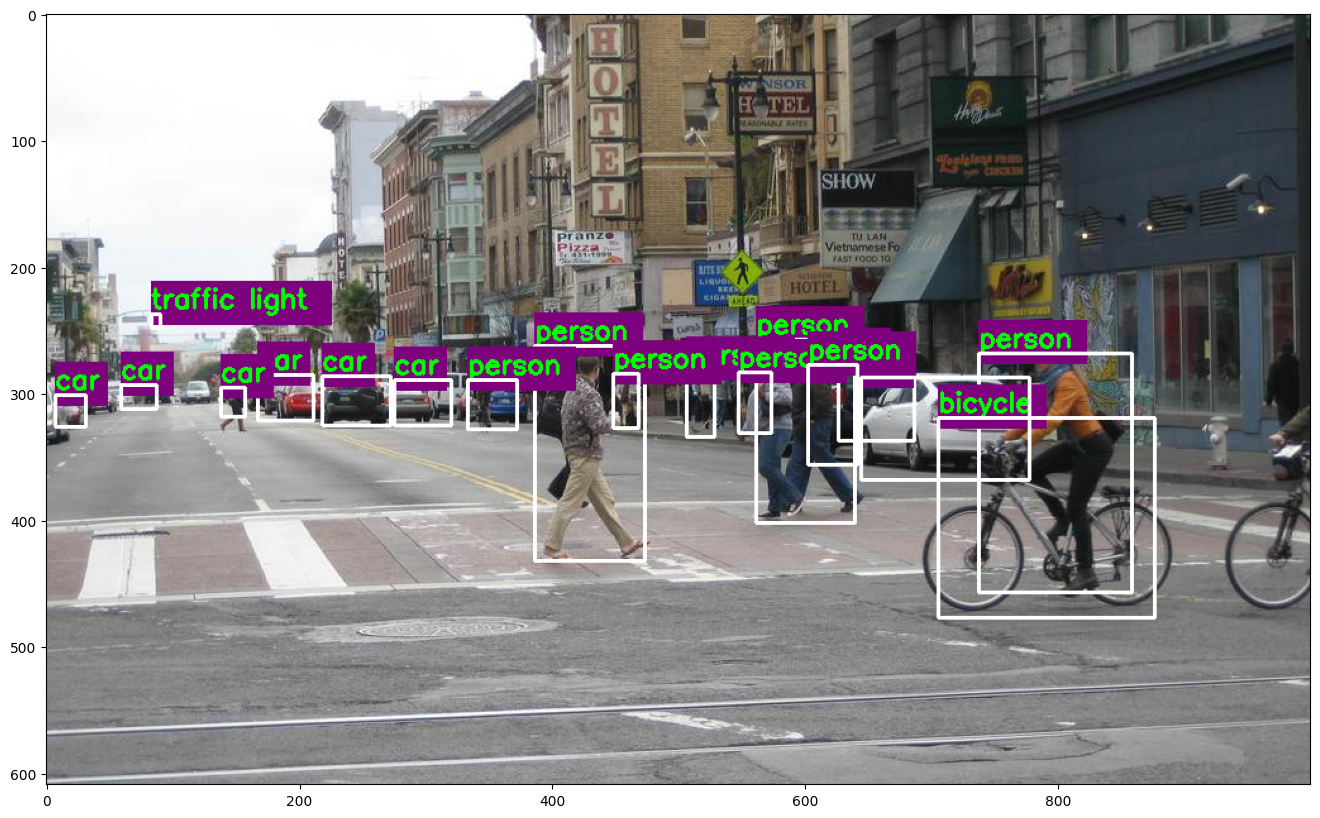

In [121]:
#Reading the image using open cv
img_1=cv2.imread('street.jpg')
#Using the de
detected_objects_1=detect(net,img_1)
display_objects(img_1,detected_objects_1)#Here the threshold is 0.3 as for default threshold above is set to it.

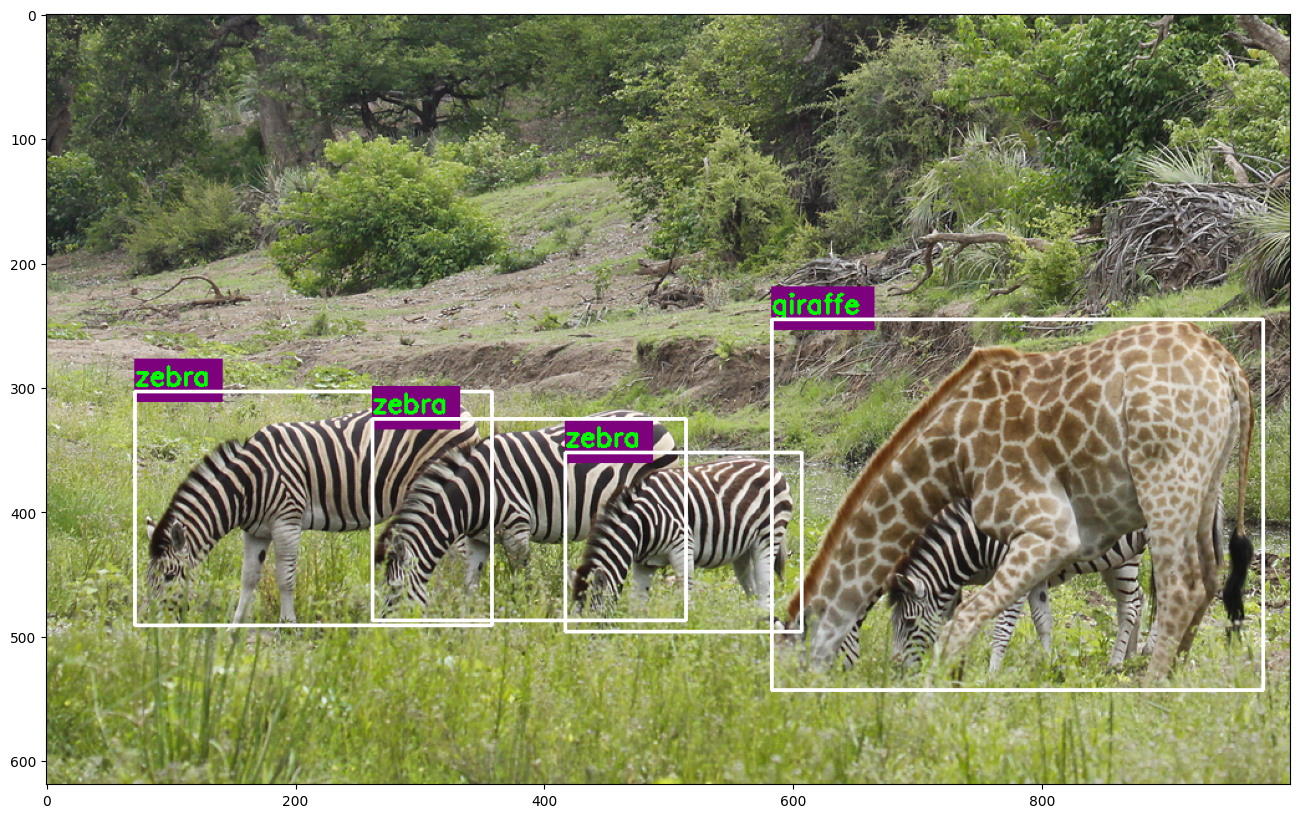

In [126]:
img_2=cv2.imread('giraffe-zebra.jpg')
detected_objects_2=detect(net,img_2)
display_objects(img_2,detected_objects_2,threshold=0.1)  #Updating the threshold

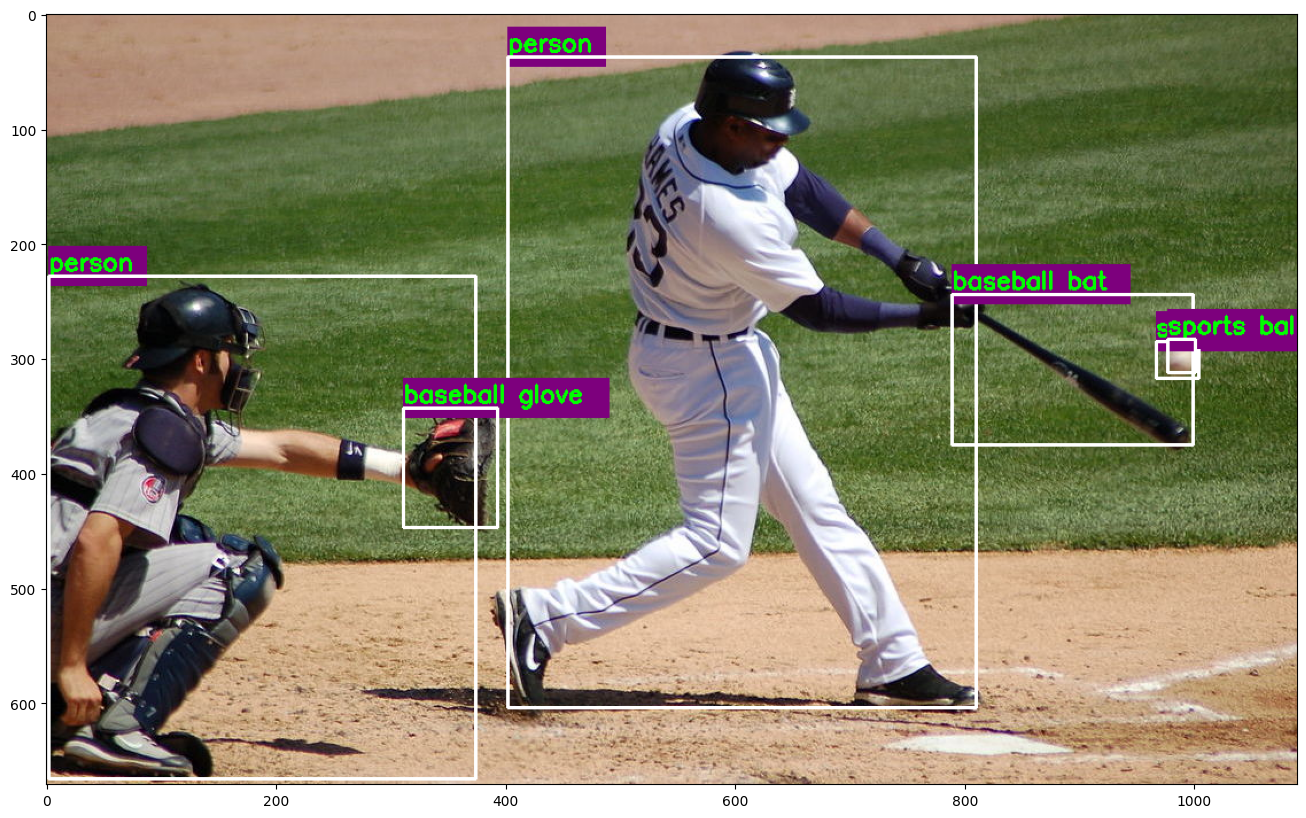

In [133]:
img3=cv2.imread('baseball.jpg')
object_detected_3=detect(net,img3)
display_objects(img3,object_detected_3)

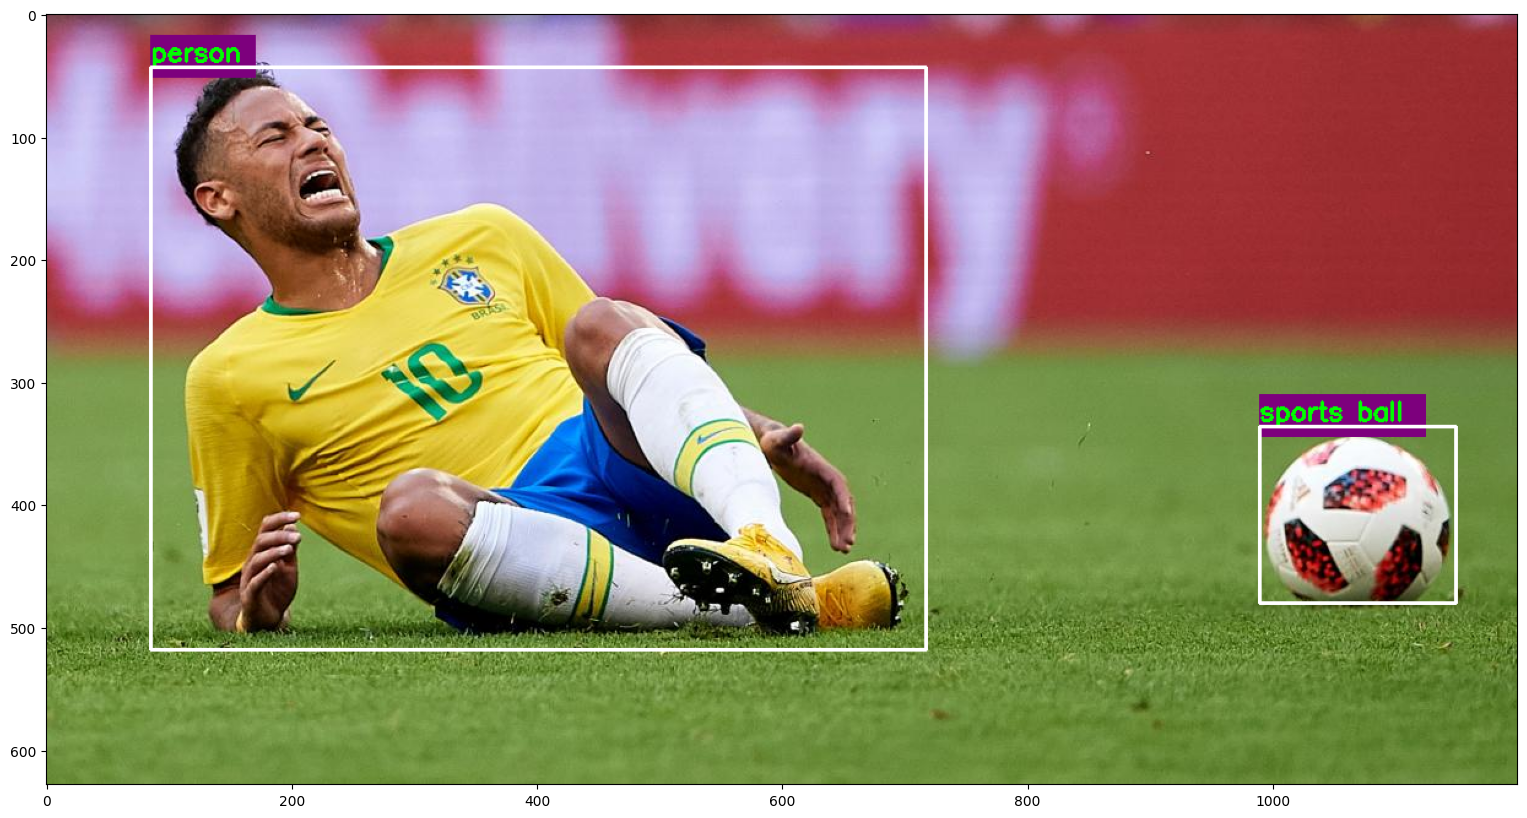

In [134]:
#False Alarm , the foot is shown as ball
img_4=cv2.imread('soccer.jpg')
object_detected_4=detect(net,img_4)
display_objects(img_4,object_detected_4,threshold=0.8)


##  Navigation

[![➡️ Module 11](https://img.shields.io/badge/Module-11-000000?style=for-the-badge&logo=github&logoColor=00FF80)](https://github.com/aypy01/opencv/tree/main/11)
&nbsp;&nbsp;&nbsp;&nbsp;
[![➡️ Module 13](https://img.shields.io/badge/Module-13-000000?style=for-the-badge&logo=github&logoColor=00FF80)](https://github.com/aypy/opencv/tree/main/13)

---

## Author
 <p align="left">
  Created and maintained by
  <a href="https://github.com/aypy01" target="_blank">&nbsp Aaditya Yadav</a>&nbsp
  <a href="https://github.com/aypy01" target="_blank">
    <img src="https://img.shields.io/badge/aypy01-000000?style=flat-square&logo=github&logoColor=00FF80" alt="GitHub Badge"/>
  </a>
</p>


---

##  License

This project is licensed under the [![License: Apache 2.0](https://img.shields.io/badge/License-Apache%202.0-blue.svg)](https://opensource.org/licenses/Apache-2.0).